In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz
import semopy
from factor_analyzer import FactorAnalyzer
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
df = pd.read_csv("https://articledatas3.s3.eu-central-1.amazonaws.com/StructuralEquationModelingData.csv")
df.head()

,PsychTest1,PsychTest2,YrsEdu,IQ,HrsTrn,HrsWrk,ClientSat,SuperSat,ProjCompl
0,62,78,5,97,6,33,84,59,34
1,46,27,2,93,7,54,55,38,56
2,68,75,2,96,5,47,70,68,38
3,55,56,4,103,7,80,63,81,78
4,51,32,4,98,5,53,55,39,56


## Tanımsal İstatistikler

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PsychTest1,1000.0,49.990,10.049920,20.0,43.00,50.0,57.0,81.0
PsychTest2,1000.0,49.286,15.019380,5.0,38.75,50.0,60.0,90.0
YrsEdu,1000.0,2.506,1.716074,0.0,1.00,3.0,4.0,5.0
IQ,1000.0,97.587,3.719175,90.0,95.00,97.0,101.0,105.0
HrsTrn,1000.0,6.028,2.484228,0.0,4.00,6.0,8.0,17.0
HrsWrk,1000.0,47.810,24.080568,0.0,30.00,47.0,64.0,100.0
ClientSat,1000.0,54.970,18.002922,0.0,43.00,55.0,67.0,100.0
SuperSat,1000.0,49.912,17.190747,0.0,38.00,50.0,62.0,100.0
ProjCompl,1000.0,48.127,20.541052,0.0,33.00,48.0,63.0,100.0


In [4]:
df.corr()

,PsychTest1,PsychTest2,YrsEdu,IQ,HrsTrn,HrsWrk,ClientSat,SuperSat,ProjCompl
PsychTest1,1.000000,0.639719,0.048526,0.022948,-0.033948,-0.042714,0.875764,0.306647,-0.040686
PsychTest2,0.639719,1.000000,0.033955,-0.004066,-0.045689,-0.067472,0.531906,0.468051,-0.067722
YrsEdu,0.048526,0.033955,1.000000,0.463767,-0.052871,-0.050526,0.173447,0.036630,0.021007
IQ,0.022948,-0.004066,0.463767,1.000000,0.024546,0.013619,0.083506,0.135298,0.052837
HrsTrn,-0.033948,-0.045689,-0.052871,0.024546,1.000000,0.816330,0.154634,0.682546,0.790964
HrsWrk,-0.042714,-0.067472,-0.050526,0.013619,0.816330,1.000000,0.110784,0.823378,0.976407
ClientSat,0.875764,0.531906,0.173447,0.083506,0.154634,0.110784,1.000000,0.390558,0.119213
SuperSat,0.306647,0.468051,0.036630,0.135298,0.682546,0.823378,0.390558,1.000000,0.808963
ProjCompl,-0.040686,-0.067722,0.021007,0.052837,0.790964,0.976407,0.119213,0.808963,1.000000


<AxesSubplot:>

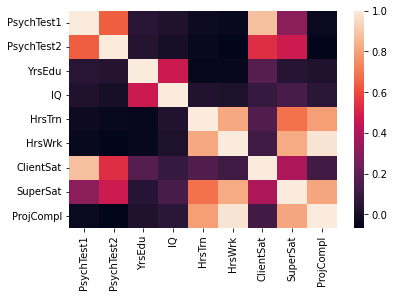

In [5]:
sns.heatmap(df.corr())

In [6]:
report = sweetviz.analyze(df)
report.show_html()

                                             |      | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


#### Değişkenler arasındaki ilişki doğrusal olmalıdır. Bunu pair plot ile görebiliriz. 

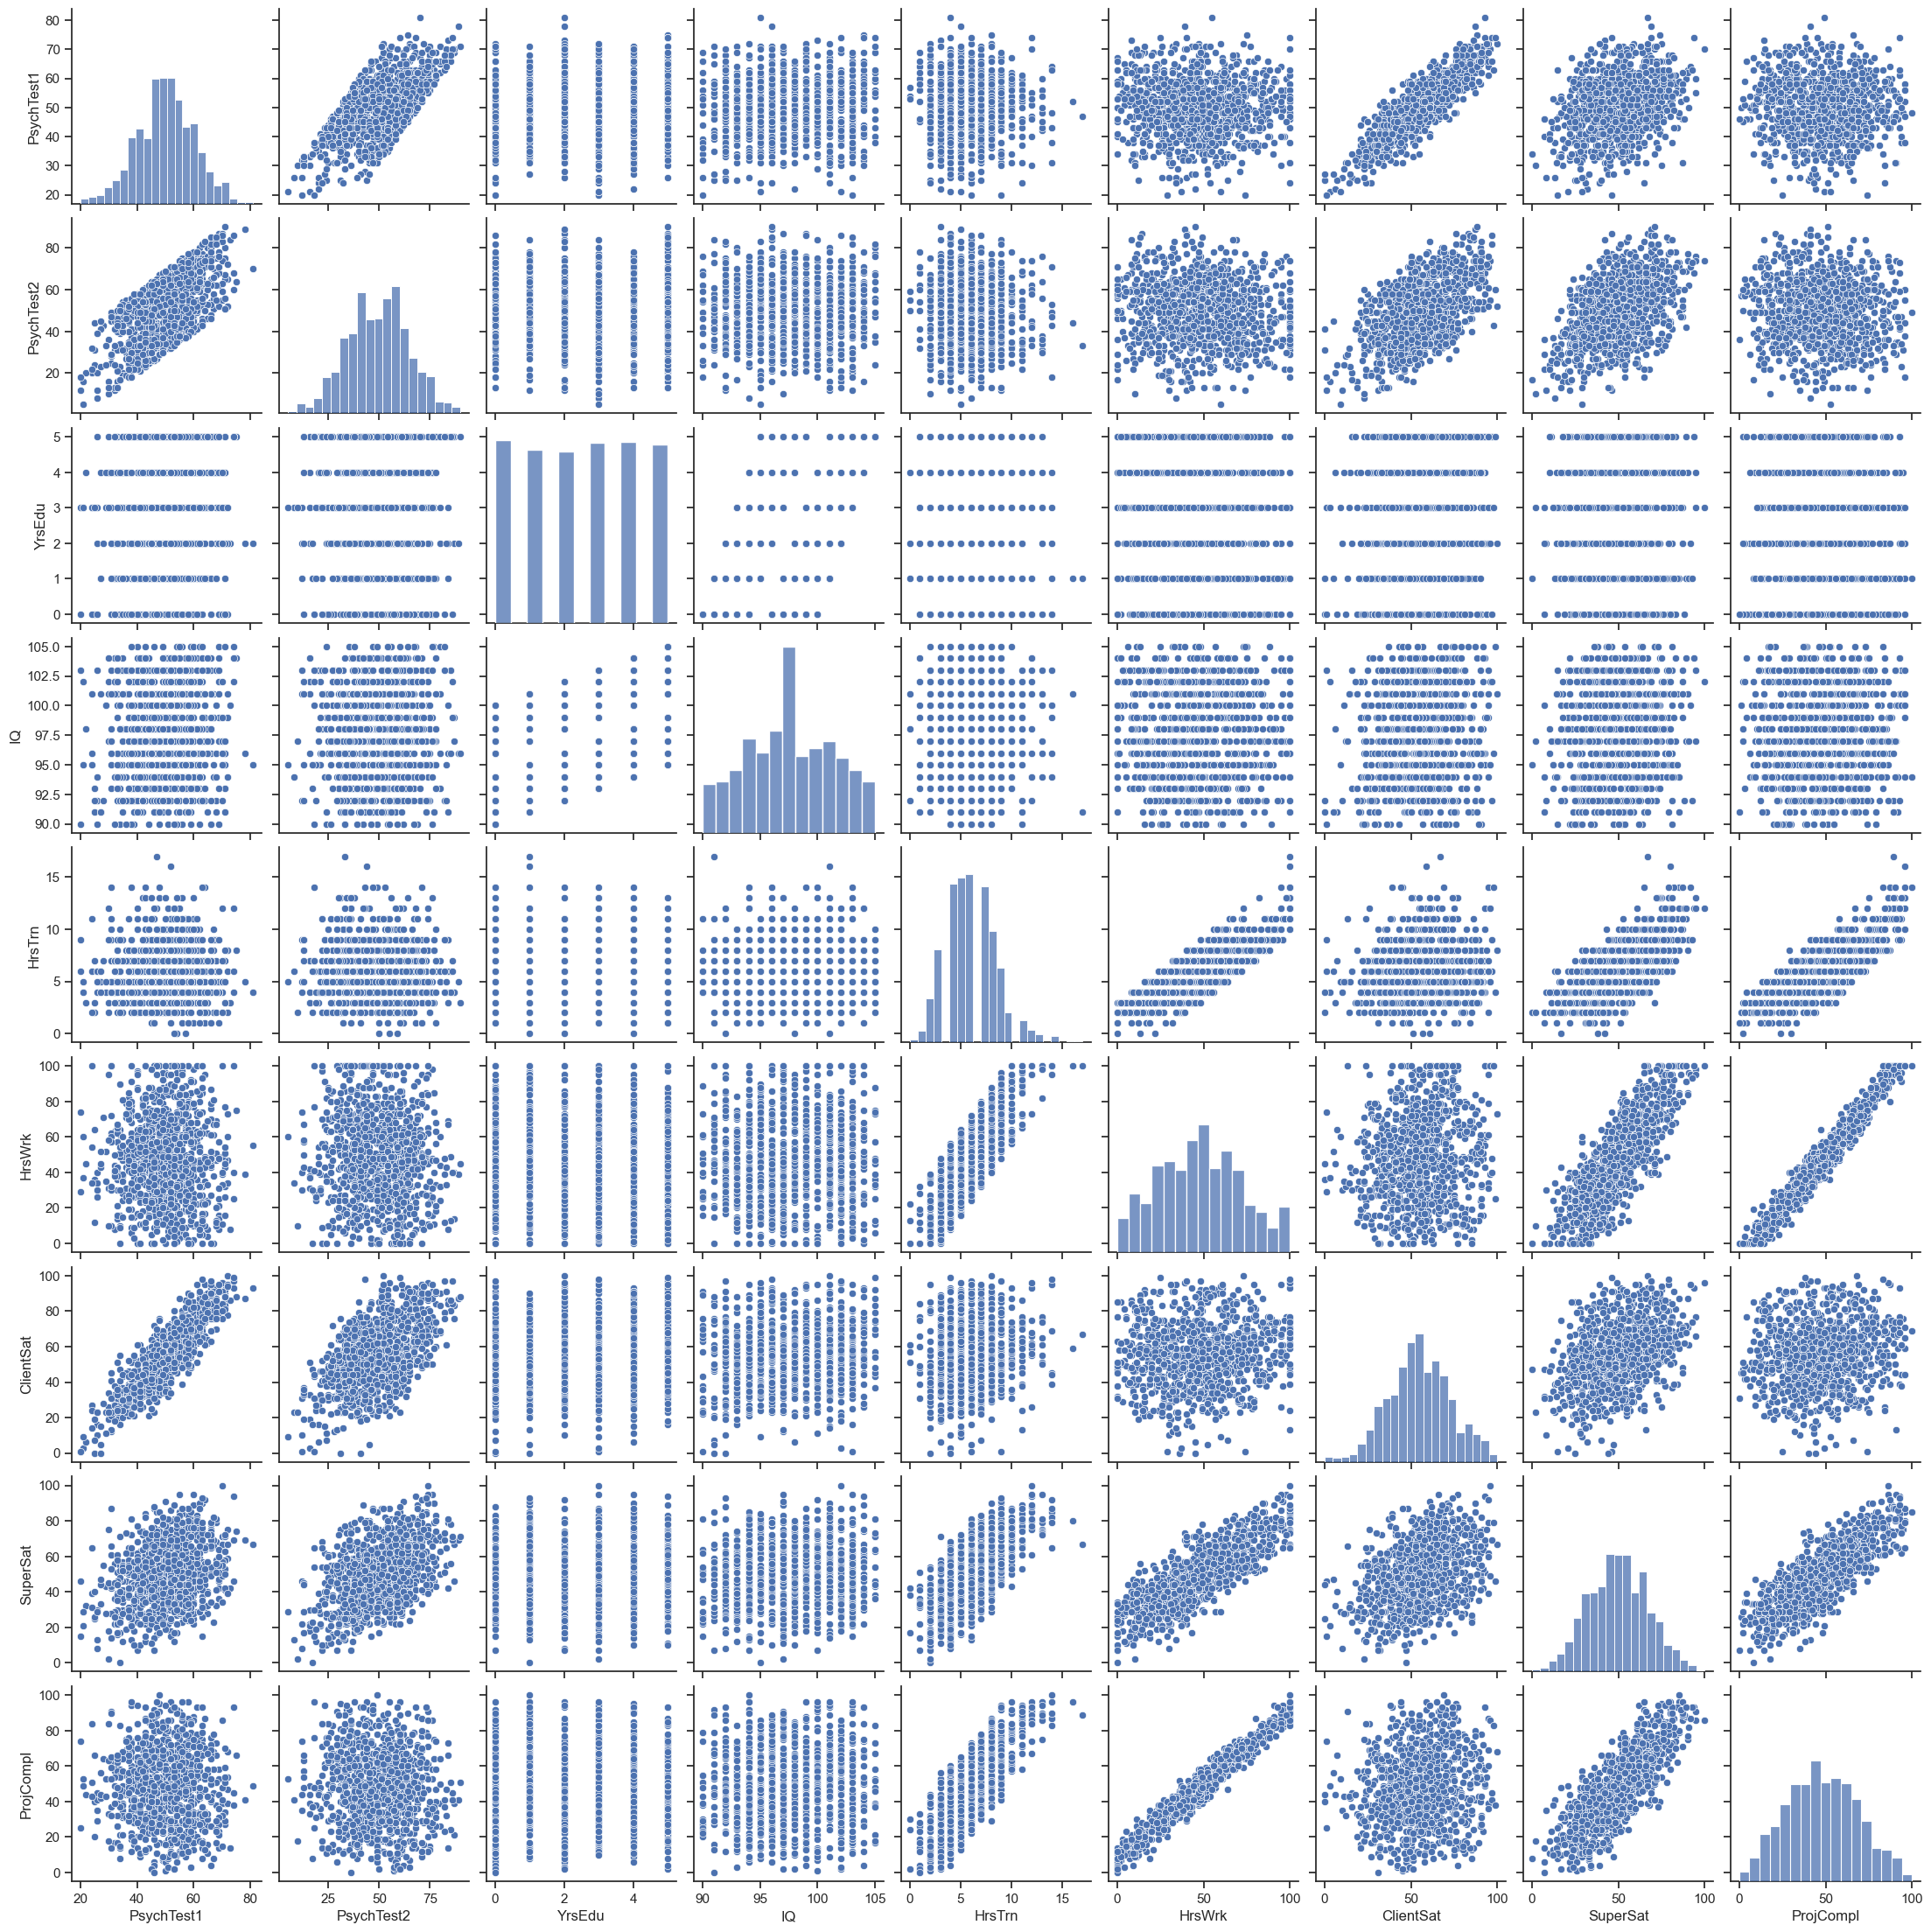

In [7]:
sns.set_theme(style="ticks")
fig = sns.pairplot(df)
fig.savefig("pair.png") 

#### Çoklu Normal Dağılım

In [8]:
from pingouin import multivariate_normality
multivariate_normality(df, alpha=.05)

HZResults(hz=982.6973016774846, pval=0.0, normal=False)

H0 red, normal dağılıma uygun değildir. 

## İşyerindeki performansla ilgili bir Yapısal Eşitlik Modelleme 

Veri setimizde, İş Performansı doğrudan ölçülemeyen bir gizli değişkendir. Burada iş performansu üç değişkene bağlıdır.
- ClientSat: Müşteri tarafından 1 ile 100 arasında bir memnuniyet derecesi
- SuperSat: Üst tarafından 1 ile 100 arasında bir İş Performansı derecesi
- ProjCompl: Başarıyla teslim edilen projelerinizin yüzdesi

İş Performansının diğer üç gizli değişkenden güçlü bir şekilde etkilendiği düşünürsek bunlar: Çalışanların Sosyal Becerileri, Entelektüel Becerileri ve Motivasyon. Bu gizli değişkenlerin her biri doğrudan ölçülemez. Bu nedenle, bağımsız gizli değişkenlerin her biri için ölçülen değişkenleri de tanımlamak gerekir. 

Gizli değişken Sosyal Beceriler, aşağıdaki iki ölçülen değişkene dayalı olacaktır:
- PsychTest1: 1-100 arası bir puan
- PsychTest2: ayrıca 1-100 arasında bir puan

Gizli değişken Entelektüel Beceriler, aşağıdaki iki ölçülen değişkene dayalı olacaktır:
- YrsEdu: Yüksek öğrenim yılı sayısı
- IQ: Bir IQ testinde puan

Gizli değişken Motivasyon, aşağıdaki iki ölçülen değişkene dayalı olacaktır:
- HrsTrain: Eğitime harcanan saat sayısı
- HrsWrk: Bir çalışma haftasındaki ortalama saat sayısı

In [9]:
data = pd.read_csv("https://articledatas3.s3.eu-central-1.amazonaws.com/StructuralEquationModelingData.csv")
data.head()

,PsychTest1,PsychTest2,YrsEdu,IQ,HrsTrn,HrsWrk,ClientSat,SuperSat,ProjCompl
0,62,78,5,97,6,33,84,59,34
1,46,27,2,93,7,54,55,38,56
2,68,75,2,96,5,47,70,68,38
3,55,56,4,103,7,80,63,81,78
4,51,32,4,98,5,53,55,39,56


In [10]:
from semopy import Model

In [11]:
model_spec = """
  # measurement model
    JobPerf =~ ClientSat + SuperSat + ProjCompl
    Social =~ PsychTest1 + PsychTest2
    Intellect =~ YrsEdu + IQ
    Motivation =~ HrsTrn + HrsWrk
  # regressions
    JobPerf ~ Social + Intellect + Motivation
"""

In [12]:
model = semopy.Model(model_spec)

In [13]:
res = model.fit(df)

In [14]:
print(model.inspect())

          lval  op        rval      Estimate   Std. Err    z-value   p-value
0      JobPerf   ~      Social  5.266010e-01   0.047422  11.104495       0.0
1      JobPerf   ~   Intellect  1.038697e+00   0.114918   9.038598       0.0
2      JobPerf   ~  Motivation  2.962484e+00   0.249086  11.893412       0.0
3    ClientSat   ~     JobPerf  1.000000e+00          -          -         -
4     SuperSat   ~     JobPerf  2.504994e+00   0.203411  12.314966       0.0
5    ProjCompl   ~     JobPerf  2.560733e+00   0.214069  11.962187       0.0
6   PsychTest1   ~      Social  1.000000e+00          -          -         -
7   PsychTest2   ~      Social  2.340357e+00   0.094652  24.725823       0.0
8       YrsEdu   ~   Intellect  1.000000e+00          -          -         -
9           IQ   ~   Intellect  4.672902e+00   0.493837   9.462445       0.0
10      HrsTrn   ~  Motivation  1.000000e+00          -          -         -
11      HrsWrk   ~  Motivation  1.187440e+01   0.270822  43.845776       0.0

In [15]:
semopy.calc_stats(model)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,21,36,3590.314654,0.0,10295.641357,0.652101,0.651278,0.402191,0.651278,0.403602,0.412477,40.819371,158.605497,3.590315


In [16]:
semopy.calc_stats(model)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,21,36,3590.314654,0.0,10295.641357,0.652101,0.651278,0.402191,0.651278,0.403602,0.412477,40.819371,158.605497,3.590315


Ki kare anlamlılık değeri 0'dır. Modelimiz verilerdeki varyasyonun yeterince önemli bir bölümünü açıklamaktadır.

In [17]:
import graphviz
g = semopy.semplot(model, "model.png")

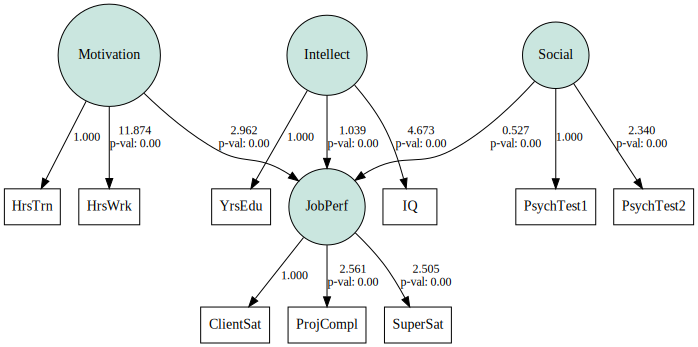

In [18]:
g

In [15]:
#directoryde rapor oluşturmak için:
semopy.report(model, "JobPerf")